In [135]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "INTC"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime.now().date()
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,INTC,26.78,26.88,26.45,26.87,32165978.0,122840.0,26.70
2016-01-05 05:00:00+00:00,INTC,26.84,26.88,26.50,26.74,17905707.0,87505.0,26.67
2016-01-06 05:00:00+00:00,INTC,26.28,26.50,25.93,26.15,26939523.0,121984.0,26.22
2016-01-07 05:00:00+00:00,INTC,25.52,26.09,25.17,25.17,41368839.0,163862.0,25.48
2016-01-08 05:00:00+00:00,INTC,25.37,25.47,24.84,24.91,32404640.0,142641.0,25.15


<Axes: xlabel='timestamp'>

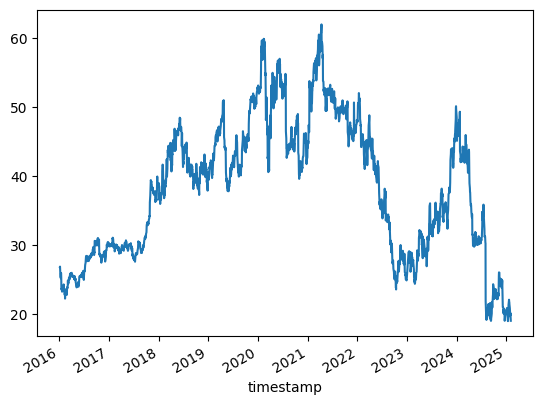

In [136]:
data["open"].plot()

In [137]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

np.random.seed(42)
data["returns"] = data["close"].pct_change()
data["volatility"] = data["returns"].rolling(window=10).std()
data["moving_avg"] = data["close"].rolling(window=10).mean()
data["price"] = data["close"]
data.dropna(inplace=True)

def create_labels(returns, threshold=0.005):
    return np.where(returns > threshold, "Buy",
                    np.where(returns < -threshold, "Sell", "Hold"))

data["rebalance_action"] = create_labels(data["returns"])
features = ["returns", "volatility", "moving_avg"]
X = data[features + ["price"]]
y = data["rebalance_action"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train.drop("price", axis=1, inplace=True)
X_test_price = X_test["price"]
X_test.drop("price", axis=1, inplace=True)

def rolling_features(X):
    df = pd.DataFrame(X, columns=features)
    df["momentum"] = df["returns"].rolling(5).mean()
    return df.fillna(0).values  # Fill NaNs from rolling operations

pipeline = Pipeline([
    ("feature_engineering", FunctionTransformer(rolling_features, validate=False)),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)),  
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])


In [138]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function rolling_features at 0x17ee73310>)),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [139]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Buy       0.79      0.75      0.77       195
        Hold       0.35      0.33      0.34        80
        Sell       0.72      0.78      0.75       180

    accuracy                           0.69       455
   macro avg       0.62      0.62      0.62       455
weighted avg       0.69      0.69      0.69       455



In [140]:
len(X_test), len(X_test_price)

(455, 455)

In [141]:
from numpy import ndarray
from pandas import DataFrame

from cira.strategy import back_test
from tqdm import tqdm


class PipeExampleStartegy(cira.strategy.Strategy):
    def __init__(self, pipeline: Pipeline):
        super().__init__(name="PipeExampleStartegy(CLASSIFIER)")
        self.pipeline = pipeline

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float) -> ndarray: 
        y_pred = self.pipeline.predict(feature_data)
        action = 0
        if portfolio.size == 0:
            return np.array([0]).astype(float) 
        if y_pred[-1] == "Buy":
            action = cash * 0.2 / prices.values[-1][0] 
        elif y_pred[-1] == "Sell" and portfolio[-1] > 0:
            action = -portfolio[-1]*0.3
        return np.array([action]).astype(float) 

In [142]:
strat = PipeExampleStartegy(pipeline)

In [143]:
X_test_price.shape

(455,)

<Axes: xlabel='timestamp'>

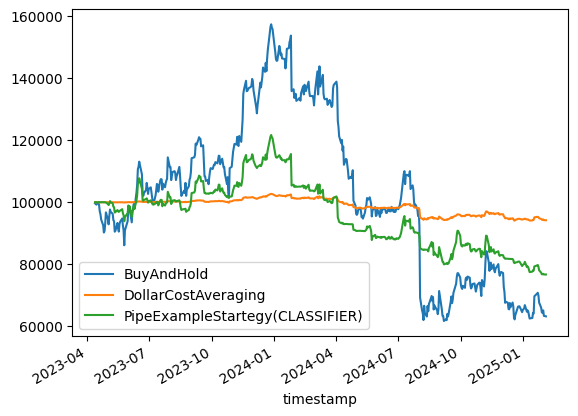

In [144]:
cira.strategy.multi_strategy_backtest([cira.strategy.ByAndHold(), cira.strategy.DollarCostAveraging(1), strat], pd.DataFrame(X_test, columns=features), X_test_price.to_frame(), 100_000).plot()

In [145]:
1 / 0

ZeroDivisionError: division by zero

In [ ]:
cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "INTC"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime.now().date()
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,INTC,26.78,26.88,26.45,26.87,32165978.0,122840.0,26.70
2016-01-05 05:00:00+00:00,INTC,26.84,26.88,26.50,26.74,17905707.0,87505.0,26.67
2016-01-06 05:00:00+00:00,INTC,26.28,26.50,25.93,26.15,26939523.0,121984.0,26.22
2016-01-07 05:00:00+00:00,INTC,25.52,26.09,25.17,25.17,41368839.0,163862.0,25.48
2016-01-08 05:00:00+00:00,INTC,25.37,25.47,24.84,24.91,32404640.0,142641.0,25.15


<Axes: xlabel='timestamp'>

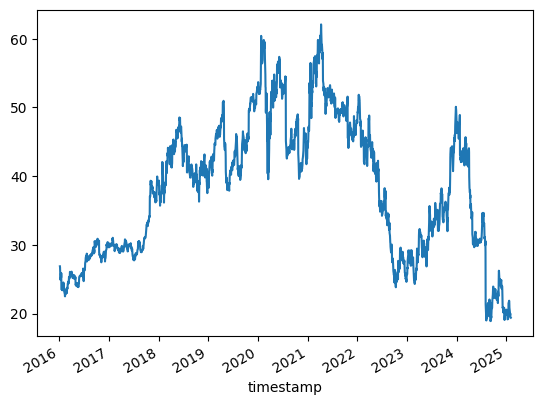

In [105]:
data["close"].plot()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.compose import ColumnTransformer

data["returns"] = data["close"].pct_change()
data["volatility"] = data["returns"].rolling(window=10).std()
data["moving_avg"] = data["close"].rolling(window=10).mean()
data.dropna(inplace=True)

def create_labels(returns, threshold=0.005):
    return np.where(returns > threshold, "Buy",
                    np.where(returns < -threshold, "Sell", "Hold"))

data["rebalance_action"] = create_labels(data["returns"])

data["allocation_pct"] = np.abs(data["returns"]) * 100  # Example allocation (0-100%)

features = ["returns", "volatility", "moving_avg"]
X = data[features]
y_classification = data["rebalance_action"]
y_regression = data["allocation_pct"]

X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)

def rolling_features(X):
    df = pd.DataFrame(X, columns=features)
    df["momentum"] = df["returns"].rolling(5).mean()
    return df.fillna(0).values  # Fill NaNs from rolling operations

classification_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

regression_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

full_pipeline = ColumnTransformer(
    transformers=[
        ("classification", classification_pipeline, features),  # For signals
        ("regression", regression_pipeline, features)  # For allocation %
    ],
    remainder="drop"
)

classification_pipeline.fit(X_train, y_train_class)
regression_pipeline.fit(X_train, y_train_reg)

y_pred_class = classification_pipeline.predict(X_test)
y_pred_reg = regression_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

print("\nMean Absolute Error (Allocation Prediction):")
print(mean_absolute_error(y_test_reg, y_pred_reg))

predicted_allocations = pd.DataFrame({
    "signal": y_pred_class,
    "allocation_pct": y_pred_reg
})
print("\nPredicted Signals and Allocations:")
print(predicted_allocations.head())


Classification Report:
              precision    recall  f1-score   support

         Buy       1.00      1.00      1.00       173
        Hold       0.99      1.00      1.00       118
        Sell       1.00      0.99      1.00       164

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455


Mean Absolute Error (Allocation Prediction):
0.02855738741095389

Predicted Signals and Allocations:
  signal  allocation_pct
0   Sell        1.293457
1   Sell        1.713530
2    Buy        2.686499
3   Hold        0.482106
4   Hold        0.043541
